In [1]:
from __future__ import annotations

import random
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym
#from dogfight_env.envs import DogfightEnv
import dogfight_env
from dogfight_env.envs import DogfightEnv


plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        shared_net_space_dim_list = [
            obs_space_dims, 64, 64, 64, 64
        ]
        self.shared_net = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(shared_net_space_dim_list[i], shared_net_space_dim_list[i+1]),
                nn.Tanh()
            )
            for i in range(len(shared_net_space_dim_list)-1)
        ])

        policy_net_space_dim_list = [
            shared_net_space_dim_list[-1], 64, 64, 64, action_space_dims
        ]
        self.policy_mean_net = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(policy_net_space_dim_list[i], policy_net_space_dim_list[i+1]),
                nn.Tanh()
            )
            for i in range(len(policy_net_space_dim_list)-1)
        ])

        policy_stddev_net_space_dim_list = [
            shared_net_space_dim_list[-1], 64, 64, 64, action_space_dims
        ]
        self.policy_stddev_net = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(policy_stddev_net_space_dim_list[i], policy_stddev_net_space_dim_list[i+1]),
                nn.Tanh()
            )
            for i in range(len(policy_stddev_net_space_dim_list)-1)
        ])

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features) * 1.5
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

In [3]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()
        action = np.clip(action, -1.5, 1.5)
        action[-1] = np.clip(action[-1], -1, 1)

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

In [4]:

obs_space_dims = 26 #env.observation_space.shape[0]
action_space_dims = 5 #env.action_space.shape[0]
agent = REINFORCE(obs_space_dims, action_space_dims)

# load the trained model
CKPT_PATH = "./checkpoints/20231213_144653_model.pth"
agent.net.load_state_dict(torch.load(CKPT_PATH))


SERVER_IP = "192.168.219.104"
SERVER_PORT = 50888

# Create and wrap the environment

env = gym.make(
    "dogfight_env/DogfightEnv-v0",
    server_ip   = SERVER_IP,
    server_port = SERVER_PORT,
    enable_builtin_autopilot = True,
    render_mode = "rgb_array"
)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward


In [5]:

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
rewards_over_seeds = []
for seed in [1]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    
    reward_over_episodes = []

    with tqdm.tqdm(total=total_num_episodes) as pbar:
        for episode in range(total_num_episodes):
            # gymnasium v26 requires users to set seed while resetting the environment
            obs, info = wrapped_env.reset(seed=seed)

            done = False
            while not done:
                my_observation = info[env.plane_names[0]]
                enemy_observation = info[env.plane_names[1]]

                pos = my_observation["pos"]
                rot = my_observation["rot"]
                v_move = my_observation["move_vector"]
                aZ = my_observation["aZ"]
                health_level = my_observation["health_level"]

                t_pos = enemy_observation["pos"]
                t_rot = enemy_observation["rot"]
                t_v_move = enemy_observation["move_vector"]
                t_aZ = enemy_observation["aZ"]
                t_health_level = enemy_observation["health_level"]

                processed_observation = np.concatenate([
                    pos, rot, v_move, aZ, [health_level],
                    t_pos, t_rot, t_v_move, t_aZ, [t_health_level]
                ], dtype=np.float32)

                action = agent.sample_action(processed_observation)
                #control_action = to_control_action(action)

                roll, pitch, yaw, thrust, fire_machine_gun = action.astype(float)
                fire_machine_gun = True if fire_machine_gun > 0.5 else False
                control_action = {}
                control_action["roll"]  = roll
                control_action["pitch"] = pitch
                control_action["yaw"]   = yaw
                control_action["thrust"] = thrust
                control_action["fire_machine_gun"] = fire_machine_gun
        
                processed_control_action = {
                    env.plane_names[0] : control_action
                }
                # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
                # These represent the next observation, the reward from the step,
                # if the episode is terminated, if the episode is truncated and
                # additional info from the step
                obs, reward, terminated, truncated, info = wrapped_env.step(
                    processed_control_action
                )

                #my_reward = reward[0]
                
                agent.rewards.append(reward)

                # End the episode wzhen either truncated or terminated is true
                #  - truncated: The episode duration reaches max number of timesteps
                #  - terminated: Any of the state space values is no longer finite.
                done = terminated or truncated

            pbar.update(1)

            reward_over_episodes.append(wrapped_env.return_queue[-1])
            agent.update()

            pbar.set_description(
                f"Episode: {episode}, Reward: {np.mean(wrapped_env.return_queue):.2f}"
            )
            if episode % 1000 == 0:
                avg_reward = int(np.mean(wrapped_env.return_queue))
                print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\hjp\anaconda3\envs\rl_test\lib\site-packages\gymnasium\utils\passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'numpy.float64'>
  logger.warn(
c:\Users\hjp\anaconda3\envs\rl_test\lib\site-packages\gymnasium\spaces\box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")
c:\Users\hjp\anaconda3\envs\rl_test\lib\site-packages\gymnasium\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\hjp\anaconda3\envs\rl_test\lib\site-packages\gymnasium\utils\passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'int'>
  logger.warn(
c:\Users\hjp\anaconda3\envs\rl_test\lib\site-packages

Episode: 0 Average Reward: -101127


Episode: 1000, Reward: -101269.29:  20%|██        | 1001/5000 [1:28:53<6:13:47,  5.61s/it]

Episode: 1000 Average Reward: -101269


Episode: 2000, Reward: -101251.66:  40%|████      | 2001/5000 [3:22:19<5:36:07,  6.72s/it]

Episode: 2000 Average Reward: -101251


Episode: 3000, Reward: -101247.19:  60%|██████    | 3001/5000 [5:17:38<3:52:02,  6.96s/it]

Episode: 3000 Average Reward: -101247


Episode: 4000, Reward: -101220.73:  80%|████████  | 4001/5000 [6:51:42<1:25:06,  5.11s/it]

Episode: 4000 Average Reward: -101220


Episode: 4999, Reward: -101206.90: 100%|██████████| 5000/5000 [8:33:30<00:00,  6.16s/it]  


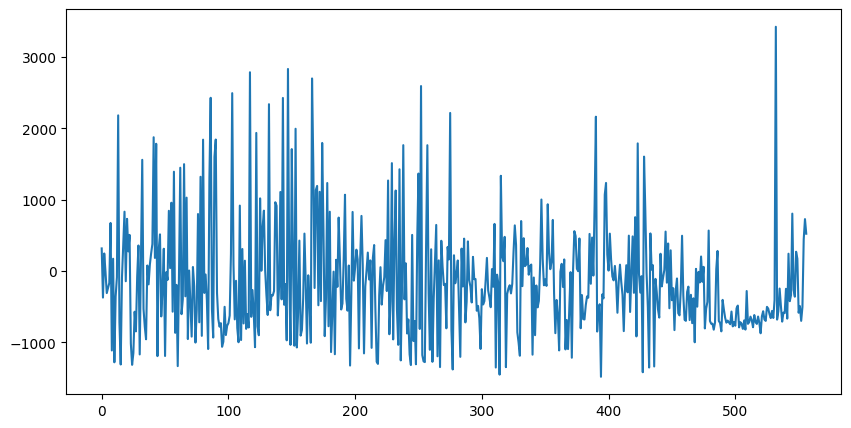

In [12]:
plt.plot(reward_over_episodes)
plt.show()

In [9]:
from copy import deepcopy

In [10]:
reward_over_episodes_backup = deepcopy(reward_over_episodes)

In [18]:
# save the model
import time
date = time.strftime("%Y%m%d_%H%M%S")
torch.save(
    agent.net.state_dict(),
    f"checkpoints/{date}_model.pth"
)

# save the rewards
import pickle
with open(f"checkpoints/rewards.pkl", "wb") as f:
    pickle.dump(reward_over_episodes, f)